In [2]:
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd

from jax.nn import softmax
from jax.config import config
from pathlib import Path
from collections import namedtuple

config.update('jax_platform_name', 'cpu')
np.set_printoptions(precision=4)
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams.update({'font.size': 18})

from grl.utils import load_info
from definitions import ROOT_DIR


In [3]:
# results_dir = Path(ROOT_DIR, 'results', 'pomdps_mi_pi')
results_dir = Path(ROOT_DIR, 'results', 'prisoners_dilemma')
# results_dir = Path(ROOT_DIR, 'results', 'pomdps_mi_dm')
vi_results_dir = Path(ROOT_DIR, 'results', 'vi')
pomdp_files_dir = Path(ROOT_DIR, 'grl', 'environment', 'pomdp_files')

args_to_keep = ['spec', 'n_mem_states', 'seed']
split_by = [arg for arg in args_to_keep if arg != 'seed']

# this option allows us to compare to either the optimal belief state soln
# or optimal state soln. ('belief' | 'state')
compare_to = 'state'

# spec_plot_order = [
#     'example_7', 'tmaze_5_two_thirds_up', 'tiger-alt-start', 'paint.95', 'cheese.95', 'network',
#     'shuttle.95', '4x3.95', 'hallway'
# ]

game_name = 'prisoners_dilemma'
leader_policies = ['all_d', 'extort', 'tit_for_tat', 'treasure_hunt', 'sugar', 'all_c', 'grudger2', 'alternator', 'majority3']

spec_plot_order = []
prisoners_spec_map = {}
for leader in leader_policies:
    spec_id = f'{game_name}_{leader}'
    prisoners_spec_map[spec_id] = leader
    spec_plot_order.append(spec_id)

spec_to_belief_state = {'tmaze_5_two_thirds_up': 'tmaze5'}



In [4]:
compare_to_list = []

for spec in spec_plot_order:
    if compare_to == 'belief':

        for fname in pomdp_files_dir.iterdir():
            if 'pomdp-solver-results' in fname.stem:
                if (fname.stem ==
                        f"{spec_to_belief_state.get(spec, spec)}-pomdp-solver-results"
                    ):
                    belief_info = load_info(fname)
                    coeffs = belief_info['coeffs']
                    max_start_vals = coeffs[belief_info['max_start_idx']]
                    spec_compare_indv = {
                        'spec': spec,
                        'compare_perf': np.dot(max_start_vals, belief_info['p0'])
                    }
                    compare_to_list.append(spec_compare_indv)
                    break
                    # print(f"loaded results for {hparams.spec} from {fname}")
        else:
            for vi_path in vi_results_dir.iterdir():
                for spec in spec_plot_order:
                    if spec_to_belief_state.get(spec, spec) in vi_path.name:
                        vi_info = load_info(vi_path)
                        max_start_vals = vi_info['optimal_vs']
                        spec_compare_indv = {
                            'spec': spec,
                            'compare_perf': np.dot(max_start_vals, vi_info['p0'])
                        }
                        compare_to_list.append(spec_compare_indv)
                        
    elif compare_to == 'state':
        for vi_path in vi_results_dir.iterdir():
            if spec_to_belief_state.get(spec, spec) in vi_path.name:
                vi_info = load_info(vi_path)
                max_start_vals = vi_info['optimal_vs']
                spec_compare_indv = {
                    'spec': spec,
                    'compare_perf': np.dot(max_start_vals, vi_info['p0'])
                }
                compare_to_list.append(spec_compare_indv)


In [5]:
compare_to_df = pd.DataFrame(compare_to_list)


In [6]:
all_results = []

for results_path in results_dir.iterdir():
    if results_path.is_dir() or results_path.suffix != '.npy':
        continue
    info = load_info(results_path)

    args = info['args']

    # agent = info['agent']
    init_policy_info = info['logs']['initial_policy_stats']
    init_improvement_info = info['logs']['greedy_initial_improvement_stats']
    final_mem_info = info['logs']['greedy_final_mem_stats']

    def get_perf(info: dict):
        return (info['state_vals_v'] * info['p0']).sum()
    single_res = {k: args[k] for k in args_to_keep}

    single_res.update({
        'init_policy_perf': get_perf(init_policy_info),
        'init_improvement_perf': get_perf(init_improvement_info),
        'final_mem_perf': get_perf(final_mem_info),
        # 'init_policy': info['logs']['initial_policy'],
        # 'init_improvement_policy': info['logs']['initial_improvement_policy'],
        # 'final_mem': np.array(agent.memory),
        # 'final_policy': np.array(agent.policy)
    })
    all_results.append(single_res)


all_res_df = pd.DataFrame(all_results)

In [7]:
cols_to_normalize = ['init_improvement_perf', 'final_mem_perf']
merged_df = all_res_df.merge(compare_to_df, on='spec')

# for col_name in cols_to_normalize:

normalized_df = merged_df.copy()
normalized_df['init_improvement_perf'] = (normalized_df['init_improvement_perf'] - merged_df['init_policy_perf']) / (merged_df['compare_perf'] - merged_df['init_policy_perf'])
normalized_df['final_mem_perf'] = (normalized_df['final_mem_perf'] - merged_df['init_policy_perf']) / (merged_df['compare_perf'] - merged_df['init_policy_perf'])
del normalized_df['init_policy_perf']
del normalized_df['compare_perf']

In [8]:
normalized_df

,spec,n_mem_states,seed,init_improvement_perf,final_mem_perf
0,prisoners_dilemma_tit_for_tat,8,2024,0.455830,1.000003
1,prisoners_dilemma_tit_for_tat,2,2020,0.455830,1.000003
2,prisoners_dilemma_tit_for_tat,2,2022,0.455830,1.000003
3,prisoners_dilemma_tit_for_tat,2,2021,0.455830,1.000003
4,prisoners_dilemma_tit_for_tat,4,2025,0.455830,1.000003
...,...,...,...,...,...
315,prisoners_dilemma_alternator,2,2028,-0.954655,1.000001
316,prisoners_dilemma_alternator,8,2025,-0.954655,1.000001
317,prisoners_dilemma_alternator,4,2023,-0.954655,1.000001
318,prisoners_dilemma_alternator,4,2020,-0.954655,1.000001


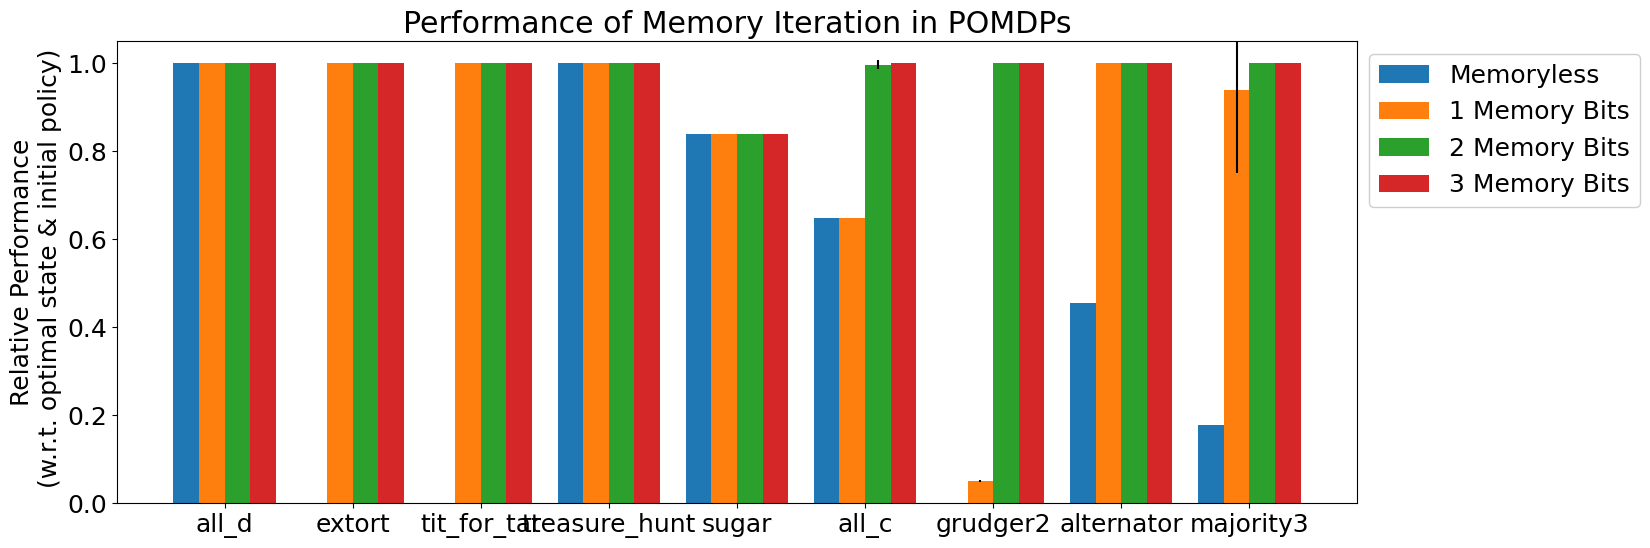

In [9]:
def maybe_spec_map(id: str):
    spec_map = {
        '4x3.95': '4x3',
        'cheese.95': 'cheese',
        'paint.95': 'paint',
        'shuttle.95': 'shuttle',
        'example_7': 'ex. 7',
        'tmaze_5_two_thirds_up': 'tmaze',
        'tiger-alt-start': 'tiger'
    }
    
    spec_map |= prisoners_spec_map
    
    if id not in spec_map:
        return id
    return spec_map[id]
groups = normalized_df.groupby(split_by, as_index=False)
means = groups.mean()
std_errs = groups.std()
num_n_mem = list(sorted(normalized_df['n_mem_states'].unique()))

group_width = 1
bar_width = group_width / (len(num_n_mem) + 2)
fig, ax = plt.subplots(figsize=(16, 6))

specs = means[means['n_mem_states'] == num_n_mem[0]]['spec']
# spec_order_mapping = [spec_plot_order.index(s) for s in specs]
spec_order_mapping = np.arange(len(specs), dtype=int)

xlabels = [maybe_spec_map(l) for l in spec_plot_order]
x = np.arange(len(specs))

init_improvement_perf_mean = np.array(means[means['n_mem_states'] == num_n_mem[0]]['init_improvement_perf'])
init_improvement_perf_std = np.array(std_errs[std_errs['n_mem_states'] == num_n_mem[0]]['init_improvement_perf'])

ax.bar(x + (0 + 1) * bar_width,
       init_improvement_perf_mean,
       bar_width,
       yerr=init_improvement_perf_std,
       label='Memoryless')

for i, n_mem_states in enumerate(num_n_mem):
    curr_mem_mean = np.array(means[means['n_mem_states'] == n_mem_states]['final_mem_perf'])
    curr_mem_std = np.array(std_errs[std_errs['n_mem_states'] == n_mem_states]['final_mem_perf'])
    ax.bar(x + (i + 2) * bar_width,
           curr_mem_mean,
           bar_width,
           yerr=curr_mem_std,
           label=f"{int(np.log2(n_mem_states))} Memory Bits")

ax.set_ylim([0, 1.05])
ax.set_ylabel(f'Relative Performance\n (w.r.t. optimal {compare_to} & initial policy)')
ax.set_xticks(x + group_width / 2)
ax.set_xticklabels(xlabels)
ax.legend(bbox_to_anchor=(1., 1.), framealpha=0.95)
ax.set_title("Performance of Memory Iteration in POMDPs")

downloads = Path().home() / 'Downloads'
fig_path = downloads / f"{results_dir.stem}.pdf"
fig.savefig(fig_path)

In [10]:
fig_path

PosixPath('/Users/ruoyutao/Downloads/prisoners_dilemma.pdf')